# Advanced Rasters

<img src="../resources/assets/river_topography.png" width="400">


<AxesSubplot:>

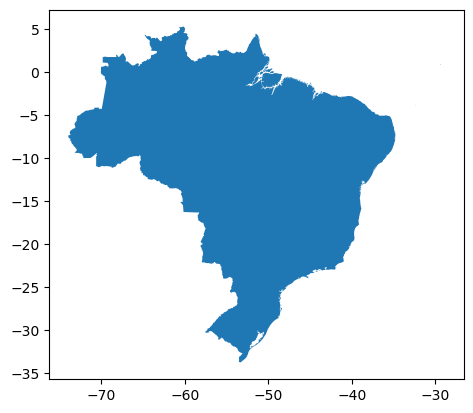

In [1]:
import geopandas as gpd

# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('../resources/data/ne_10m_admin_0_countries.shp')

brazil = df.loc[df['ADMIN'] == 'Brazil']
brazil.plot()

In [2]:
import os
from rasterio.enums import Resampling
from rasterio.transform import Affine
import rasterio

scale = 10
with rasterio.open("../resources/data/ETOPO1_Bed_g_geotiff.tif") as src:
    new_height = src.height // scale
    new_width = src.width // scale
    # Read and downsample
    data = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.mode
    )
    # Calculate the new transform
    new_transform = src.transform * Affine.scale(scale)

    # Save the downsampled image
    profile = src.profile
    profile.update({
        'height': new_height,
        'width': new_width,
        'transform': new_transform
    })
    with rasterio.open("../resources/data/downsampled_topography.tif", 'w', **profile) as dst:
        dst.write(data)


In [3]:
import rasterio

topography_file = rasterio.open('../resources/data/downsampled_topography.tif')

In [4]:
from rasterio import mask as msk 
from shapely.geometry import mapping

clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)

In [5]:
import numpy as np

print(np.amin(clipped_array))
print(np.amax(clipped_array))

-28
1975


In [6]:
clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=-28)

In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm
import matplotlib.pyplot as plt

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 2002))
background_colour = np.array([0.0, 0.0, 0.0, 0.0])
colors_land[:1, :] = background_colour
newcmp_topo = ListedColormap(colors_land)

bounds = np.arange(-28, 1975, 1)
norm_topo = BoundaryNorm(bounds, newcmp_topo.N)

## Raster -> Points

<img src="../resources/assets/raster2point.png" width="600">


In [8]:
import pandas as pd

rows, cols = clipped_array[0].shape
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Calculate the real-world coordinates
xs, ys = rasterio.transform.xy(clipped_transform, row_indices.flatten(), col_indices.flatten())

# Create a DataFrame
df = pd.DataFrame({
    'X': xs,
    'Y': ys,
    'Value': clipped_array[0].flatten()
})

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

print(gdf)

               X          Y  Value                     geometry
0     -74.091667   5.258333    -28    POINT (-74.09167 5.25833)
1     -73.925000   5.258333    -28    POINT (-73.92500 5.25833)
2     -73.758333   5.258333    -28    POINT (-73.75833 5.25833)
3     -73.591667   5.258333    -28    POINT (-73.59167 5.25833)
4     -73.425000   5.258333    -28    POINT (-73.42500 5.25833)
...          ...        ...    ...                          ...
63915 -29.591667 -33.741667    -28  POINT (-29.59167 -33.74167)
63916 -29.425000 -33.741667    -28  POINT (-29.42500 -33.74167)
63917 -29.258333 -33.741667    -28  POINT (-29.25833 -33.74167)
63918 -29.091667 -33.741667    -28  POINT (-29.09167 -33.74167)
63919 -28.925000 -33.741667    -28  POINT (-28.92500 -33.74167)

[63920 rows x 4 columns]


<AxesSubplot:>

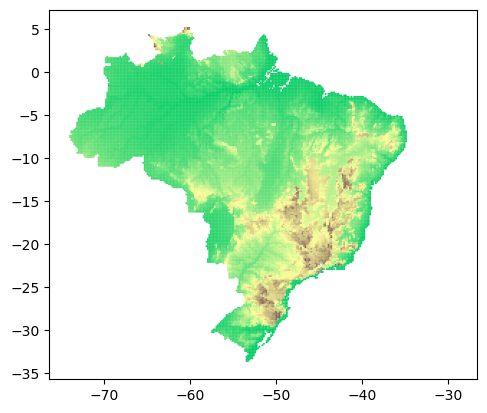

In [9]:
gdf.plot(column='Value', s=2, cmap=newcmp_topo, norm=norm_topo, edgecolors='none')

## Raster -> LineStrings

<img src="../resources/assets/raster2lines.png" width="600">


In [10]:
from osgeo import gdal, ogr, osr
from rasterio.transform import from_origin

#(originX, pixelWidth, rotX, originY, rotY, pixelHeight)
gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

#in memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)
mem_raster.SetGeoTransform(gdal_transform)
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# in memory ogr layer for contours
drv = ogr.GetDriverByName('Memory')
mem_ds = drv.CreateDataSource('')
contour_lyr = mem_ds.CreateLayer(
    'contours',
    geom_type=ogr.wkbLineString25D
)

#define attributes
for name, ftype in [('ID', ogr.OFTInteger), ('ELEV', ogr.OFTReal)]:
    fld = ogr.FieldDefn(name, ftype)
    contour_lyr.CreateField(fld)

#create contours
gdal.ContourGenerate(mem_raster.GetRasterBand(1), 50, -11, [], 0, 0, contour_lyr, 0, 1)


0

In [11]:
from shapely.geometry import LineString

lines = [LineString(np.array(contour.GetGeometryRef().GetPoints())) for contour in contour_lyr]
elev = [contour.GetField('elev') for contour in contour_lyr]
gdf = gpd.GeoDataFrame(pd.DataFrame({'elev': elev}), crs="EPSG:4326", geometry=lines)
print(gdf)

        elev                                           geometry
0     1289.0  LINESTRING Z (-60.18133 5.09167 1289.00000, -6...
1     1339.0  LINESTRING Z (-60.23407 5.09167 1339.00000, -6...
2      839.0  LINESTRING Z (-60.05577 4.92500 839.00000, -60...
3      889.0  LINESTRING Z (-60.46691 4.92500 889.00000, -60...
4      889.0  LINESTRING Z (-60.06331 4.92500 889.00000, -60...
...      ...                                                ...
2860   239.0  LINESTRING Z (-53.40459 -32.07500 239.00000, -...
2861    89.0  LINESTRING Z (-53.24500 -32.24167 89.00000, -5...
2862    39.0  LINESTRING Z (-53.24124 -32.40833 39.00000, -5...
2863   -11.0  LINESTRING Z (-52.75833 -32.76548 -11.00000, -...
2864   -11.0  LINESTRING Z (-53.15913 -33.57500 -11.00000, -...

[2865 rows x 2 columns]


<AxesSubplot:>

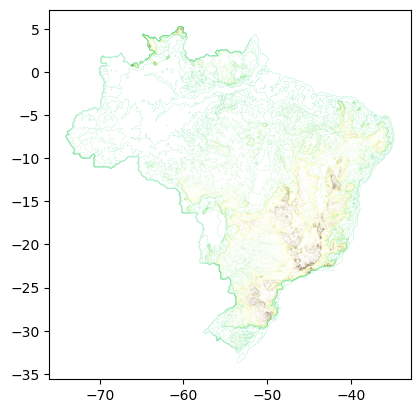

In [12]:
gdf.plot(lw=0.1, column='elev', cmap=newcmp_topo, norm=norm_topo)

## Exercise

- Combine everything you have learned into a single map. Generate an OS style map of topography, rivers and forests by combining all of the data layers into one map.

<img src="../resources/assets/river_topography.png" width="400">


C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


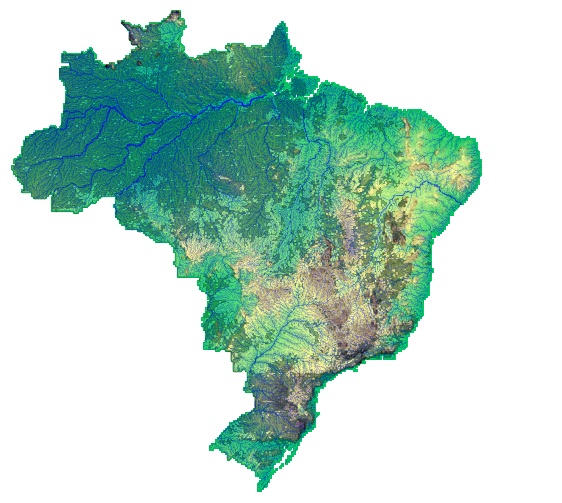

In [13]:
from rasterio.plot import show

samerica_rivers = gpd.read_parquet("../resources/data/rivers.parquet.gzip")

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 1 - 0.1
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.1 + (valueScaled * rightSpan)

forests_file = rasterio.open('../resources/data/downsampled_forest.tif')
clipped_array_forests, clipped_transform_forests = rasterio.mask.mask(forests_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)
clipped_array_forests[clipped_array_forests > 0] = 1

greens = cm.get_cmap('Greens', 2)
newcolors = greens(np.linspace(0, 1, 2))
newcolors[:1, :] = np.array([0.0, 0.0, 0.0, 0.0])
newcmp_forests = ListedColormap(newcolors)
bounds = np.arange(2)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)


fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=newcmp_topo, norm=norm_topo)
show(clipped_array_forests, ax=ax, transform=clipped_transform_forests, cmap=newcmp_forests, norm=norm_forests, alpha=0.4)
gdf.plot(lw=0.05, ax=ax, column='elev', color='black')
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'])
ax.axis('off')
plt.show()

## Raster -> Polygons

<img src="../resources/assets/raster2polygon.png" width="600">


In [14]:
from osgeo import gdal, ogr
from osgeo import osr
from rasterio.transform import from_origin

gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

# Create an in-memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)

# Set the geotransform
mem_raster.SetGeoTransform(gdal_transform)

# Write the data
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# Create an in-memory vector layer
mem_drv_vector = ogr.GetDriverByName('Memory')
mem_vector = mem_drv_vector.CreateDataSource('out')
mem_layer = mem_vector.CreateLayer('polygonized_raster', geom_type=ogr.wkbPolygon)

# Add a new field to store raster values
new_field = ogr.FieldDefn('DN', ogr.OFTInteger)
mem_layer.CreateField(new_field)

# Polygonize the raster to the in-memory vector layer
gdal.Polygonize(mem_raster.GetRasterBand(1), None, mem_layer, 0, [], callback=None)


0

In [15]:
from shapely.geometry import Polygon

geoms = []
vals = []

# Access the polygons
for feature in mem_layer:
    geom = feature.GetGeometryRef()
    
    # Extract the coordinates from the geometry
    ring = geom.GetGeometryRef(0)
    coordinates = []
    for i in range(ring.GetPointCount()):
        x, y = ring.GetX(i), ring.GetY(i)
        coordinates.append((x, y))
        
    geoms.append(Polygon(coordinates))
    vals.append(feature.GetField('DN'))

gdf = gpd.GeoDataFrame(pd.DataFrame({'vals': vals}), crs='EPSG:4326', geometry=geoms)

print(gdf)

       vals                                           geometry
0      1071  POLYGON ((-60.67500 5.17500, -60.67500 5.00833...
1       838  POLYGON ((-60.50833 5.17500, -60.50833 5.00833...
2      1362  POLYGON ((-60.34167 5.17500, -60.34167 5.00833...
3      1204  POLYGON ((-60.17500 5.17500, -60.17500 5.00833...
4      1145  POLYGON ((-60.67500 5.00833, -60.67500 4.84167...
...     ...                                                ...
23477     8  POLYGON ((-53.50833 -33.32500, -53.50833 -33.4...
23478    14  POLYGON ((-53.34167 -33.32500, -53.34167 -33.6...
23479    16  POLYGON ((-53.17500 -33.32500, -53.17500 -33.4...
23480     9  POLYGON ((-53.50833 -33.49167, -53.50833 -33.6...
23481   -28  POLYGON ((-74.17500 5.34167, -74.17500 -33.825...

[23482 rows x 2 columns]


<AxesSubplot:>

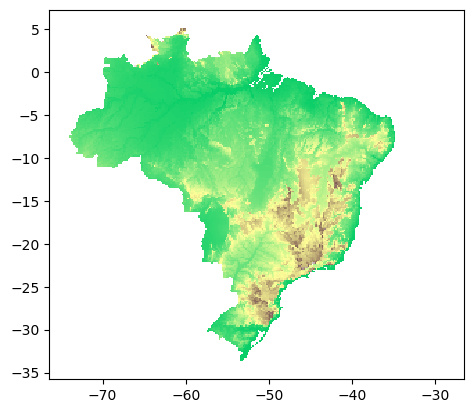

In [16]:
gdf.plot(column='vals', cmap=newcmp_topo, norm=norm_topo)